In [2]:
from read_simulation_data.get_foreground_variable import get_foreground_variable
from read_simulation_data.get_background_variable import get_background_variable
from read_simulation_data.get_num_snaps import get_num_snaps
from read_simulation_data.get_info import get_info
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
import numpy as np
import os
import visualize_background as vb
import astropy.units as u

from plot_simulation_data.plot_foreground_variable_2D import plot_foreground_variable_2D
from plot_simulation_data.plot_foreground_variable_1D import plot_foreground_variable_1D
from plot_simulation_data.plot_all_foreground_variables_2D import plot_all_foreground_variables_2D
from plot_simulation_data.plot_all_foreground_variables_1D import plot_all_foreground_variables_1D
from plot_simulation_data.animate_all_foreground_variables_1D import animate_all_foreground_variables_1D
from plot_simulation_data.animate_all_foreground_variables_2D import animate_all_foreground_variables_2D
from plot_simulation_data.plot_foreground_variable_cross_section_3D import plot_foreground_variable_cross_section_3D
from plot_simulation_data.plot_all_foreground_variables_cross_section_3D import plot_all_foreground_variables_cross_section_3D
from plot_simulation_data.animate_all_foreground_variables_across_axis_3D import animate_all_foreground_variables_across_axis_3D

from plot_simulation_data.plot_conservation_of_mass_2D import plot_conservation_of_mass_2D

DATA_FOLDER = "/mn/stornext/d10/data/tabjone/data/"
R_SUN = 6.957e10

/usr/lib64/python3.9/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.1)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


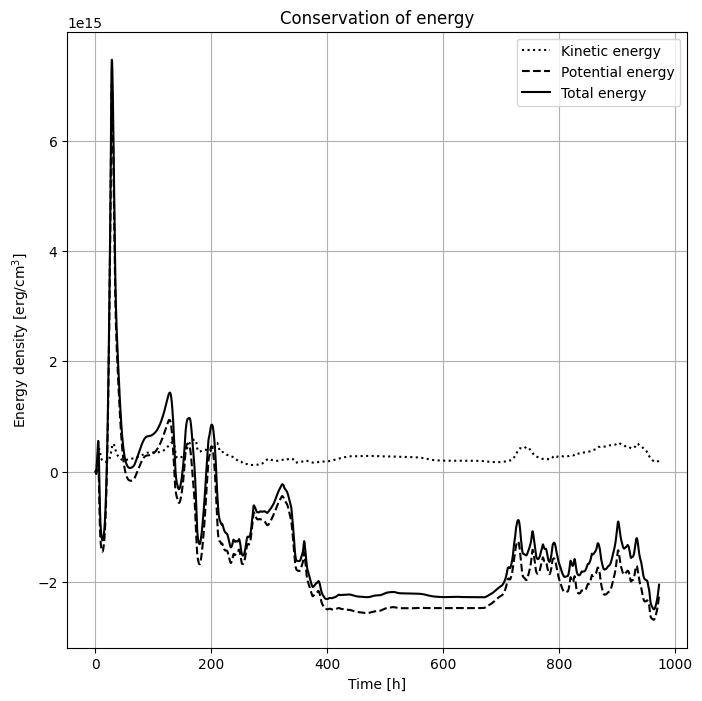

In [5]:
def get_energies(folder, snap_number):

    vz, unit, _ = get_foreground_variable(folder, snap_number, 'vz')
    vz = vz * u.Unit(unit)
    vy, unit, _ = get_foreground_variable(folder, snap_number, 'vy')
    vy = vy * u.Unit(unit)
    s1, unit, t = get_foreground_variable(folder, snap_number, 's1')
    s1 = s1 * u.Unit(unit)

    t = t * u.Unit('s')

    constants_dict, global_params_dict, grid_info_dict = get_info(folder)
    dz, unit = grid_info_dict['dz']
    dz = dz * u.Unit(unit)

    gamma = global_params_dict['GAMMA'][0]
    mu = constants_dict['MU'][0]
    m_u, unit = constants_dict['M_U']
    m_u = m_u * u.Unit(unit)
    k_b, unit = constants_dict['K_B']
    k_b = k_b * u.Unit(unit)

    c_p = k_b / (mu * m_u) / (1.0-1.0/gamma)

    r, unit = get_background_variable(folder, 'r')
    r = r * u.Unit(unit)
    g, unit = get_background_variable(folder, 'g')
    g = g * u.Unit(unit)
    rho0, unit = get_background_variable(folder, 'rho0')
    rho0 = rho0 * u.Unit(unit)

    g_top = g[-1]
    r_top = r[-1]

    phi = np.cumsum(g) * dz + g_top * r_top

    kinetic_energy = rho0[:,np.newaxis] * (vz**2 + vy**2)/2
    potential_energy = - (rho0 * phi)[:,np.newaxis] * s1/c_p

    total_energy = kinetic_energy + potential_energy

    return kinetic_energy.to("erg cm-3"), potential_energy.to("erg cm-3"), total_energy.to("erg cm-3"), t



def plot_conservation_of_energy_2D(folder, ax, snap_number, key, **kwargs):
    num_snaps = get_num_snaps(folder)

    if kwargs.get('plot_interval') is not None:
        plot_interval = 1
    else:
        plot_interval = kwargs.get('plot_interval')
    plot_range = range(0, num_snaps, plot_interval)
    size = len(list(plot_range))

    kinetic_energy_array = np.zeros(size) * u.Unit('g cm-1 s^-2')
    potential_energy_array = np.zeros(size) * u.Unit('g cm-1 s^-2')
    total_energy_array = np.zeros(size) * u.Unit('g cm-1 s^-2')

    t = np.zeros(size) * u.s
    i = 0
    for j in plot_range:
        kinetic_energy, potential_energy, total_energy, t_snap = get_energies(folder, j)
        kinetic_energy = np.sum(kinetic_energy)
        potential_energy = np.sum(potential_energy)
        total_energy = np.sum(total_energy)

        kinetic_energy_array[i] = kinetic_energy
        potential_energy_array[i] = potential_energy
        total_energy_array[i] = total_energy

        t[i] = t_snap
        i+=1
    t_return = t[-1]
    t = t.to('h')

    ax.set_title("Conservation of energy")
    ax.set_xlabel("Time [h]")
    ax.set_ylabel("Energy density [erg/cm$^3$]")

    ax.plot(t, kinetic_energy_array[:], label='Kinetic energy', linestyle="dotted", color="black")
    ax.plot(t, potential_energy_array[:], label='Potential energy', linestyle="dashed", color="black")
    ax.plot(t, total_energy_array[:], label='Total energy', color="black")
    # log plot
    #ax.set_yscale('log')
    ax.legend()
    ax.grid(True)
    im = 0

    return im, t_return, kinetic_energy_array, potential_energy_array, total_energy_array, t


fig, ax = plt.subplots(figsize=(8,8))
RUN_NAME = "test_on_off_velocity_cut/"
_, _, kinetic_energy, potential_energy, total_energy, t = plot_conservation_of_energy_2D(DATA_FOLDER+RUN_NAME, ax, 0, 'vz', plot_interval=1000)
#plt.savefig('data/new_run_2/conservation_of_energy.png', dpi=300)

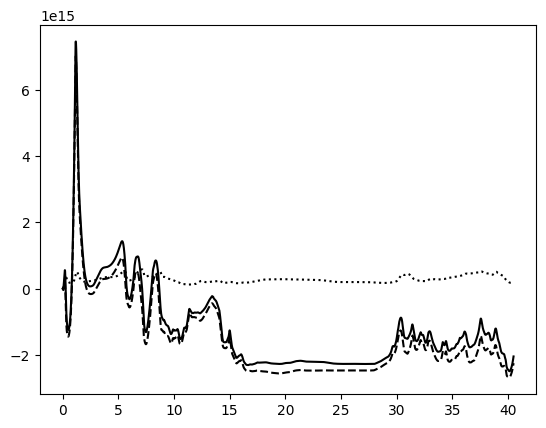

In [12]:
plt.plot(t.to('day'), kinetic_energy.value, label='Kinetic energy', linestyle="dotted", color="black")
plt.plot(t.to("day"), potential_energy.value, label='Potential energy', linestyle="dashed", color="black")
plt.plot(t.to("day"), total_energy.value, label='Total energy', color="black")

([<matplotlib.lines.Line2D at 0x7f55291b6490>], 0.0)

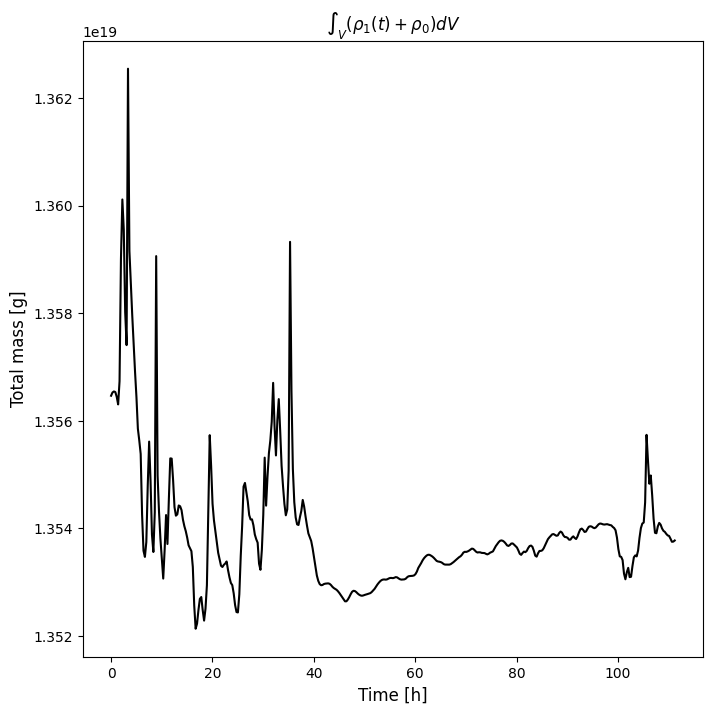

In [3]:
def plot_conservation_of_mass_2D(folder, ax, snap_number, key, **kwargs):
    rho0, unit = get_background_variable(folder, 'rho0')
    rho0 = rho0 * u.Unit(unit) * u.cm

    num_snaps = get_num_snaps(folder)

    if kwargs.get('plot_interval') is not None:
        plot_interval = 1
    else:
        plot_interval = kwargs.get('plot_interval')
    plot_range = range(0, num_snaps, plot_interval)
    size = len(list(plot_range))

    constants_dict, global_params_dict, grid_info_dict = get_info(folder)
    dz, unit = grid_info_dict['dz']
    dz = dz * u.Unit(unit)
    dy, unit = grid_info_dict['dy']
    dy = dy * u.Unit(unit)

    t = np.zeros(size) * u.s

    total_mass = np.zeros(size) * rho0.unit * u.cm * u.cm

    i = 0
    for j in plot_range:
        rho1, unit, t_current = get_foreground_variable(folder, j, 'rho1')
        rho1 = rho1 * u.Unit(unit) * u.cm

        total_mass[i] = np.sum(rho1 + rho0[:,np.newaxis]) * dz * dy

        t[i] = t_current * u.s
        i+=1

    t_return = t[snap_number].value
    
    t = t.to(u.h)

    ax.set_title(r"$\int_{V}(\rho_1(t)+\rho_0) dV$")
    ax.set_xlabel("Time [{}]".format(t.unit), fontsize=12)
    ax.set_ylabel("Total mass [{}]".format(total_mass.unit), fontsize=12)

    im = ax.plot(t[:], total_mass[:], color='black')

    return im, t_return

fig, ax = plt.subplots(figsize=(8,8))

plot_conservation_of_mass_2D(DATA_FOLDER+'return_to_old_22/', ax, 0, 'rho1', plot_interval=15)
#plt.savefig('data/new_run_2/conservation_of_mass_full.png', dpi=200)

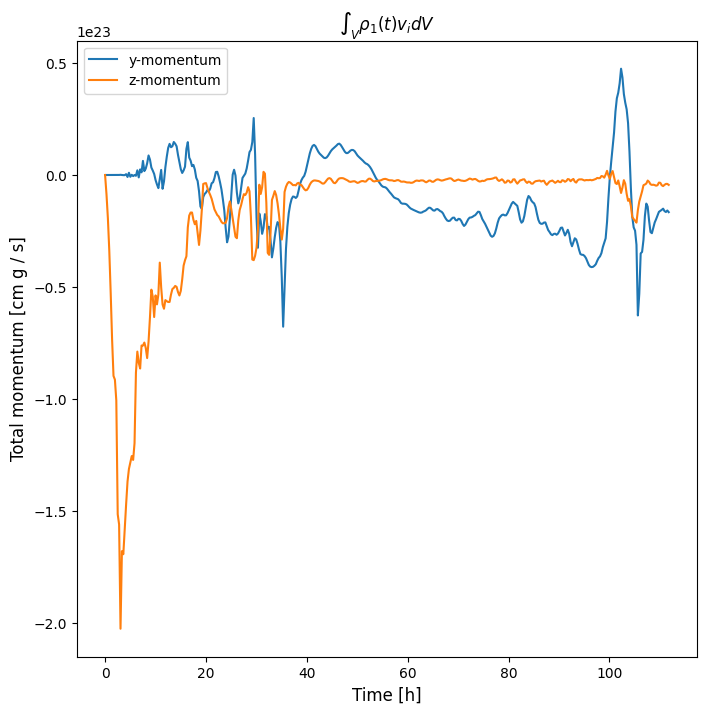

In [4]:
def plot_conservation_of_momentum_2D(folder, ax, snap_number, key, **kwargs):

    num_snaps = get_num_snaps(folder)

    if kwargs.get('plot_interval') is not None:
        plot_interval = 1
    else:
        plot_interval = kwargs.get('plot_interval')
    plot_range = range(0, num_snaps, plot_interval)
    size = len(list(plot_range))

    constants_dict, global_params_dict, grid_info_dict = get_info(folder)
    dz, unit = grid_info_dict['dz']
    dz = dz * u.Unit(unit)
    dy, unit = grid_info_dict['dy']
    dy = dy * u.Unit(unit)

    t = np.zeros(size) * u.s

    total_momentum_y = np.zeros(size) * u.Unit('g cm s^-1')
    total_momentum_z = np.zeros(size) * u.Unit('g cm s^-1')

    i = 0
    for j in plot_range:
        rho1, unit, t_current = get_foreground_variable(folder, j, 'rho1')
        rho1 = rho1 * u.Unit(unit) * u.cm

        vy, unit, _ = get_foreground_variable(folder, j, 'vy')
        vy = vy * u.Unit(unit)
        vz, unit, _ = get_foreground_variable(folder, j, 'vz')
        vz = vz * u.Unit(unit)

        total_momentum_y[i] = np.sum(rho1 * vy) * dz * dy
        total_momentum_z[i] = np.sum(rho1 * vz) * dz * dy

        t[i] = t_current * u.s
        i+=1

    t_return = t[snap_number].value

    t = t.to(u.h)

    ax.set_title(r"$\int_{V}\rho_1(t) v_i dV$")
    ax.set_xlabel("Time [{}]".format(t.unit), fontsize=12)
    ax.set_ylabel("Total momentum [{}]".format(total_momentum_y.unit), fontsize=12)

    im1 = ax.plot(t[:], total_momentum_y[:], label="y-momentum")
    im2 = ax.plot(t[:], total_momentum_z[:], label="z-momentum")

    return [im1,im2], t_return

fig, ax = plt.subplots(figsize=(8,8))
plot_conservation_of_momentum_2D(DATA_FOLDER+'return_to_old_22/', ax, 0, 'rho1', plot_interval=15)
ax.legend()
#plt.savefig('data/new_run_2/conservation_of_momentum.png', dpi=200)